# 어제 실습과제 리뷰 (Day3)

0. 문제정의
* 휴먼 활동 데이터를 이용하여 활동의 종류를 6가지 중 하나로 예측하는 다항분류
* 평가지표: 정확도 90%

In [1]:
# 1. 데이터 적재
import pandas as pd
train = pd.read_csv('datasets/human_activity_train.csv')
test = pd.read_csv('datasets/human_activity_test.csv')

In [46]:
train['subject'].unique()

array([ 1,  3,  5,  6,  7,  8, 11, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26,
       27, 28, 29, 30], dtype=int64)

In [47]:
test['subject'].unique()

array([ 2,  4,  9, 10, 12, 13, 18, 20, 24], dtype=int64)

In [27]:
# 전처리 중 원핫인코더: 2D => 2D (ndarray)
# 이 방법이 기술적으로는 가능하나 좋지 않은 방법임. 
# 시험데이터는 모르는 데이터라고 가정해야 하므로.
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from pandas import Series
# sub_categories = np.arange(1, 31)
concat_subject = np.concatenate(
    [train['subject'].unique(), test['subject'].unique()],axis=0)
sub_categories = np.unique(concat_subject).reshape(-1, 1)
               
oh = OneHotEncoder(sparse=False)
oh.fit(sub_categories)
X_train_oh = oh.transform(train[['subject']])
X_test_oh = oh.transform(test[['subject']])

C:\Users\shbaek\anaconda3\envs\lgchem\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\shbaek\anaconda3\envs\lgchem\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [48]:
# 전처리 중 원핫인코더: 2D => 2D (ndarray)
# 이 방법이 맞는 방법
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from pandas import Series
               
oh = OneHotEncoder(sparse=False, handle_unknown='ignore')
oh.fit(train[['subject']])
X_train_oh2 = oh.transform(train[['subject']])
X_test_oh2 = oh.transform(test[['subject']])

원핫인코더는 데이터셋 중 범주형 열을 벡터화(수치화) 할 때 사용함

In [49]:
X_train_oh2[:500:100]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [50]:
X_test_oh2[:500:100]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

라벨 인코더는 타겟레이블을 정수로 변환할 때 사용함

In [33]:
# 전처리 중 라벨인코더: : 1D => 1D (ndarray)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['Activity'])
y_train_le = le.transform(train['Activity'])
y_test_le = le.transform(test['Activity'])

In [35]:
print(train['Activity'].value_counts())
Series(y_train_le).value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64


0    1407
2    1374
1    1286
3    1226
5    1073
4     986
dtype: int64

In [36]:
print(test['Activity'].value_counts())
Series(y_test_le).value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64


0    537
2    532
3    496
1    491
5    471
4    420
dtype: int64

In [2]:
X_train = train.iloc[:, :-2] # subject, Activity 제외
X_test = test.iloc[:, :-2] # subject, Activity 제외
y_train = train['Activity']
y_test = test['Activity']
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7352, 561) (7352,) (2947, 561) (2947,)


이상치 처리 (1.5*IQR)

In [127]:
# 이상치가 1000개 이상인 열 이름 구하기
import numpy as np
import pandas as pd

cnames = X_train.columns
q1 = X_train.quantile(0.25)
q3 = X_train.quantile(0.75)

iqr = q3 - q1
upper = np.array(q3 + 1.5*iqr)
lower = np.array(q1 - 1.5*iqr)

out_columns = Series(np.where((X_train > upper) | (X_train < lower))[1]).value_counts()
indices = out_columns[out_columns >= 1000].index
cnames[indices]

Index(['tBodyAccJerk-mean()-X', 'tBodyGyro-mean()-X', 'tBodyGyroJerk-mean()-X',
       'tBodyAccJerk-mean()-Y', 'tBodyGyroJerk-mean()-Y',
       'tBodyAccJerk-mean()-Z', 'tBodyGyroJerk-mean()-Z', 'tBodyGyro-mean()-Y',
       'tBodyAcc-mean()-X', 'tBodyGyro-mean()-Z', 'tGravityAcc-mean()-X',
       'tGravityAcc-max()-X', 'tGravityAcc-min()-X', 'tGravityAcc-energy()-X',
       'angle(X,gravityMean)', 'fBodyAccJerk-bandsEnergy()-57,64.2',
       'fBodyAccJerk-bandsEnergy()-57,64.1', 'fBodyGyro-bandsEnergy()-57,64.1',
       'fBodyAccJerk-bandsEnergy()-57,64', 'fBodyAcc-bandsEnergy()-57,64',
       'fBodyAcc-bandsEnergy()-57,64.1', 'tBodyAcc-mean()-Z',
       'fBodyGyro-bandsEnergy()-57,64.2', 'fBodyGyro-bandsEnergy()-57,64',
       'fBodyAcc-bandsEnergy()-57,64.2', 'fBodyGyro-maxInds-X',
       'tBodyAcc-mean()-Y', 'tGravityAcc-energy()-Y',
       'tGravityAcc-entropy()-Y', 'angle(tBodyAccMean,gravity)',
       'tGravityAcc-energy()-Z'],
      dtype='object')

<AxesSubplot:>

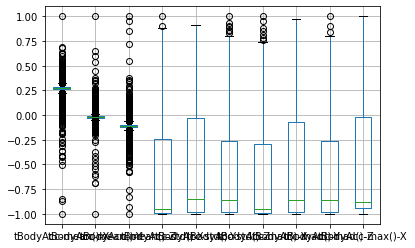

In [121]:
X_train.iloc[:, :10].boxplot()

(7352, 561) (561,)


<AxesSubplot:>

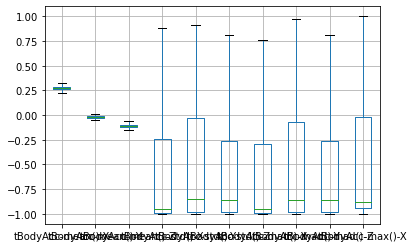

In [122]:
# 아래 코드는 X_train에 다시 치환하는 부분이 포함되므로 한 번만 실행할 것.
import numpy as np
import pandas as pd

cnames = X_train.columns
q1 = X_train.quantile(0.25)
q3 = X_train.quantile(0.75)

iqr = q3 - q1
upper = np.array(q3 + 1.5*iqr)
lower = np.array(q1 - 1.5*iqr)

X_train = np.where(X_train > upper, upper, X_train)
print(X_train.shape, upper.shape)
X_train = np.where(X_train < lower, lower, X_train)

X_train = pd.DataFrame(X_train, columns=cnames)
X_train.iloc[:, :10].boxplot()

In [3]:
from sklearn.preprocessing import StandardScaler
zs = StandardScaler()
X_train_zs = zs.fit_transform(X_train)
X_test_zs = zs.transform(X_test)

In [75]:
DecisionTreeClassifier?

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)
tree_clf.score(X_test, y_test)

0.8676620291822192

In [73]:
np.argsort(tree_clf.feature_importances_)[-10:]

array([ 37, 222,  57, 159, 448,  74, 508, 559, 393,  52], dtype=int64)

In [83]:
X_train.columns[np.argsort(tree_clf.feature_importances_)][::-1][:10]

Index(['tGravityAcc-min()-X', 'fBodyAccJerk-bandsEnergy()-1,24',
       'angle(Y,gravityMean)', 'fBodyAccMag-energy()',
       'tGravityAcc-arCoeff()-Z,2', 'fBodyGyro-maxInds-X',
       'tBodyGyro-correlation()-Y,Z', 'tGravityAcc-energy()-Y',
       'tGravityAccMag-arCoeff()1', 'tBodyAcc-correlation()-X,Y'],
      dtype='object')

In [80]:
print(tree_clf.max_depth)

None


In [81]:
from sklearn.tree import export_graphviz
export_graphviz(tree_clf, 
                out_file='activity_tree.dot', 
                feature_names=X_train.columns,
               class_names=y_train.unique(), 
               rounded=True,
               filled=True)

In [82]:
!type activity_tree.dot

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="tGravityAcc-min()-X <= 0.096\ngini = 0.831\nsamples = 7352\nvalue = [1407, 1286, 1374, 1226, 986, 1073]\nclass = STANDING", fillcolor="#fffefe"] ;
1 [label="gini = 0.0\nsamples = 1407\nvalue = [1407, 0, 0, 0, 0, 0]\nclass = STANDING", fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="fBodyAccJerk-bandsEnergy()-1,24 <= -0.97\ngini = 0.797\nsamples = 5945\nvalue = [0, 1286, 1374, 1226, 986, 1073]\nclass = LAYING", fillcolor="#fbfffd"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="angle(Y,gravityMean) <= 0.14\ngini = 0.499\nsamples = 2660\nvalue = [0, 1286, 1374, 0, 0, 0]\nclass = LAYING", fillcolor="#f2fdf7"] ;
2 -> 3 ;
4 [label="tGravityAcc-energy()-Y <= -1.0\ngini = 0.234\nsamples = 1357\nvalue = [0, 1173, 184, 0, 0, 0]\nclass = SITTING", fillcolor="#ace958"] ;
3 -> 4 ;
5 [label

151 [label="gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 1, 0]\nclass = WALKING_DOWNSTAIRS", fillcolor="#8139e5"] ;
150 -> 151 ;
152 [label="gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 0, 1]\nclass = WALKING_UPSTAIRS", fillcolor="#e5399d"] ;
150 -> 152 ;
153 [label="tGravityAcc-max()-X <= 0.89\ngini = 0.162\nsamples = 80\nvalue = [0, 0, 0, 1, 6, 73]\nclass = WALKING_UPSTAIRS", fillcolor="#e74ca6"] ;
143 -> 153 ;
154 [label="fBodyAccJerk-bandsEnergy()-17,24 <= -0.459\ngini = 0.077\nsamples = 76\nvalue = [0, 0, 0, 1, 2, 73]\nclass = WALKING_UPSTAIRS", fillcolor="#e641a1"] ;
153 -> 154 ;
155 [label="tBodyAccJerkMag-mean() <= -0.518\ngini = 0.027\nsamples = 74\nvalue = [0, 0, 0, 1, 0, 73]\nclass = WALKING_UPSTAIRS", fillcolor="#e53c9e"] ;
154 -> 155 ;
156 [label="gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 1, 0, 0]\nclass = WALKING", fillcolor="#399de5"] ;
155 -> 156 ;
157 [label="gini = 0.0\nsamples = 73\nvalue = [0, 0, 0, 0, 0, 73]\nclass = WALKING_UPSTAIRS", fillcolor="#e5399d"] ;
155

In [84]:
tree_clf.get_depth()

18

특정 파라미터를 세부 튜닝할 때 사용하는 과적합 그래프 그리기

In [85]:
(np.arange(1, 11, 1) * 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
[0.1, 0.4, 0.7, 1.0] # 이와 같이 max_features 튜닝할 후보값을 준비하면 됨.

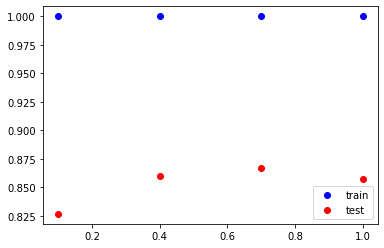

In [89]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
train_acc = []
test_acc = []
for k in (np.arange(1, 11, 3) * 0.1):
    tree_clf = DecisionTreeClassifier(max_features=k)
    tree_clf.fit(X_train, y_train)
    train_acc.append(tree_clf.score(X_train, y_train))
    test_acc.append(tree_clf.score(X_test, y_test))
ax.scatter((np.arange(1, 11, 3) * 0.1), train_acc, label='train', color='blue')
ax.scatter((np.arange(1, 11, 3) * 0.1), test_acc, label='test', color='red')
plt.legend(loc='best')
plt.show()

# 앙상블 프로세스 (배깅, 부스팅)
## 랜덤포레스트 (배깅)
* 배깅: Bootstrap Aggregating (BAGGING)
    * 병렬처리 방식
    * 결과를 취합하는 방식: 분류(다수결), 회귀(평균값)

In [133]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=100)
rnd_clf.fit(X_train, y_train)
print(rnd_clf.score(X_train, y_train))
print(rnd_clf.score(X_test, y_test))

1.0
0.9256871394638616


# 부스팅
* 직렬
* AdaBoost

In [141]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(tree_clf, n_estimators=100)
ada_clf.fit(X_train, y_train)
print(ada_clf.score(X_train, y_train))
print(ada_clf.score(X_test, y_test))

1.0
0.8544282321004412


In [142]:
!pip install xgboost

  Using cached xgboost-1.6.1-py3-none-win_amd64.whl (125.4 MB)


In [6]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

xgb_clf = XGBClassifier(n_estimators=10)
xgb_clf.fit(X_train, y_train_le)
print(xgb_clf.score(X_train, y_train_le))
print(xgb_clf.score(X_test, y_test_le))

0.9976877040261154
0.9144893111638955


In [7]:
XGBClassifier?

# 회귀 (수치예측)

In [10]:
concrete = pd.read_excel('datasets/Concrete_Data.xls')
concrete.columns = ['cement', 'slag', 'ash', 'water', 'superplastic', 
                    'coarseagg', 'findagg', 'age', 'strength']

strength 열(압축강도)을 예측하는 수치예측

In [11]:
concrete.tail()

,cement,slag,ash,water,superplastic,coarseagg,findagg,age,strength
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.401235


<AxesSubplot:>

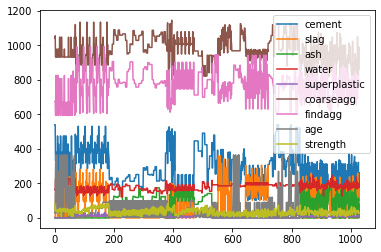

In [12]:
concrete.plot()

In [14]:
X = concrete.iloc[:, :-1]
y = concrete['strength']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from sklearn.preprocessing import StandardScaler
zs = StandardScaler()
X_train_zs = zs.fit_transform(X_train)
X_test_zs = zs.transform(X_test)

(824, 8) (824,) (206, 8) (206,)


## 선형회귀 (정규방정식)

In [15]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [16]:
lin_reg.intercept_, lin_reg.coef_

(-28.63573935657591,
 array([ 0.11897516,  0.10851781,  0.08216854, -0.13571192,  0.30873202,
         0.01780436,  0.02406104,  0.11644448]))

In [23]:
print(lin_reg.score(X_train, y_train)) # R^2 (결정계수: 1 - (잔차/퍼짐정도))
print(lin_reg.score(X_test, y_test))

0.6104593527939592
0.6275416055429022


In [21]:
import numpy as np
np.argsort(np.abs(lin_reg.coef_))[::-1][:3]

array([4, 3, 0], dtype=int64)

In [22]:
concrete.columns[np.argsort(np.abs(lin_reg.coef_))[::-1][:3]]

Index(['superplastic', 'water', 'cement'], dtype='object')

In [ ]:
X[['superplastic', 'water', 'cement']]

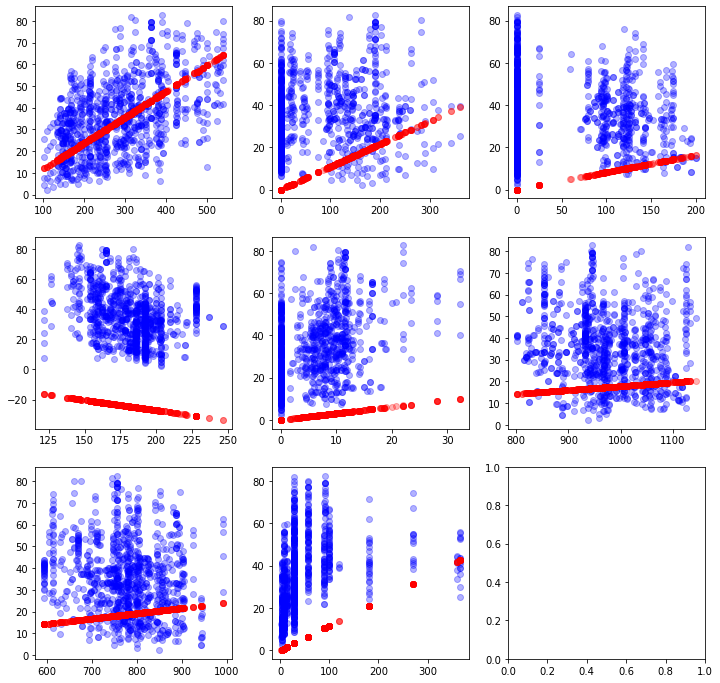

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, cname in enumerate(X.columns):
    xdata = X[cname]
    ydata = y
    
    ydata2 = lin_reg.coef_[i]*xdata
    
    r = i//3
    c = i%3
    ax[r, c].scatter(xdata, ydata, color='blue', alpha=0.3)
    ax[r, c].scatter(xdata, ydata2, color='red', alpha=0.3)
plt.show()

## SGDRegressor

In [36]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X_train_zs, y_train)

SGDRegressor(eta0=0.1, max_iter=50, penalty=None)

In [37]:
print(sgd_reg.score(X_train_zs, y_train)) # R^2 (결정계수: 1 - (잔차/퍼짐정도))
print(sgd_reg.score(X_test_zs, y_test))

0.6042714923684864
0.6010085205604819


## 릿지 (L2 norm)

In [39]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X_train_zs, y_train)

Ridge(alpha=1, solver='cholesky')

In [40]:
print(ridge_reg.score(X_train_zs, y_train))
print(ridge_reg.score(X_test_zs, y_test))

0.61043344009452
0.6275641808582495


## 라쏘 (L1 norm)

In [45]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_zs, y_train)

Lasso(alpha=0.1)

In [46]:
print(lasso_reg.score(X_train_zs, y_train))
print(lasso_reg.score(X_test_zs, y_test))

0.6081712278817049
0.6258353226823946


## 엘라스틱넷 (ElasticNet)

In [47]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X_train_zs, y_train)

ElasticNet(alpha=0.1)

In [48]:
print(elastic_net.score(X_train_zs, y_train))
print(elastic_net.score(X_test_zs, y_test))

0.6003655826976186
0.6166798274932458
